# Doctors' locations

- Each location will be assigned to the number of doctors in this location, thus it will be represented with a histogram.

In [101]:
import json
import numpy as np
import collections
import matplotlib.pyplot as plt
from locations import company_provinces
from locations import cairo_cities
from locations import alexandria_cities
from locations import giza_cities
from locations import dakahlia_cities
from locations import sharkia_cities

biotech_id = '5dc7b030a7180339745e658e'

# Define the path to your JSON file
customers_file_path = 'dataset/customers.json'
companies_file_path = 'dataset/companies.json'
trackers_file_path = 'dataset/trackers.json'

# Open the file and load the contents as a Python object
with open(customers_file_path) as f:
    customers = json.load(f)

with open(companies_file_path) as f:
    companies = json.load(f)

with open(trackers_file_path) as f:
    trackers = json.load(f)

# Now you can access the data just like any other Python object
trackers[0]


{'_id': {'$oid': '5f04d5b8a6239f001792f103'},
 'company_id': {'$oid': '5b3b4b3335a5880e703ef673'},
 'user_id': {'$oid': '5e79f34480e96b0017ccd2d6'},
 'month_year': 'July-2020',
 'events': [{'_id': {'$oid': '5f04d5b8a6239f001792f104'},
   'type': 'login',
   'device': 'Android',
   'app': 'carrier',
   'timestamp': {'$date': '2020-07-07T20:06:16.795Z'}},
  {'_id': {'$oid': '5f071ea4a8a9ea001770a678'},
   'type': 'login',
   'device': 'Android',
   'app': 'carrier',
   'timestamp': {'$date': '2020-07-09T13:41:56.631Z'}},
  {'_id': {'$oid': '5f071ea5a8a9ea001770a679'},
   'type': 'login',
   'device': 'Android',
   'app': 'carrier',
   'timestamp': {'$date': '2020-07-09T13:41:57.335Z'}},
  {'_id': {'$oid': '5f071ea6a8a9ea001770a67a'},
   'type': 'login',
   'device': 'Android',
   'app': 'carrier',
   'timestamp': {'$date': '2020-07-09T13:41:58.055Z'}}],
 '__v': 0}

In [102]:
# ========== ----- ========== Trackers Analysis ========== ----- ========== #
# Get tracker events with type:call & distanceDeviation > 0

call_events = []
all_events_count = 0
reps_ids = []
companies_ids = []

for tracker in trackers:
    for event in tracker['events']:
        if (event['type'] == 'call'):
            all_events_count += 1
            if tracker['company_id']['$oid'] != biotech_id and 'geoLocation' in event and 'distanceDeviation' in event and event['distanceDeviation'] > 0:
                reps_ids.append(tracker['user_id']['$oid'])
                companies_ids.append(tracker['company_id']['$oid'])
                
                event['user_id'] = tracker['user_id']
                event['company_id'] = tracker['company_id']
                call_events.append(event)

call_events_count = len(call_events)


In [103]:
print("Total number of events: ", all_events_count)
print("Number of call events with distance deviation: ", call_events_count, "\n")


reps_ids = list(set(reps_ids))  # remove duplicates from rep's ids
companies_ids = list(set(companies_ids))  # remove duplicates from rep's ids
print("Number of companies that use distance deviation feature: ", len(companies_ids))
print("Number of reps that use distance deviation feature: ", len(reps_ids))

Total number of events:  332532
Number of call events with distance deviation:  13637 

Number of companies that use distance deviation feature:  1
Number of reps that use distance deviation feature:  33


In [104]:

# Get reps & their customers

reps_customers_count = {}
for companies_id in companies_ids:
    for company in companies:
        if company['_id']['$oid'] == companies_id:
            for customer in company['customers']:
                for user in customer['users']:
                    if user['$oid'] in reps_ids:
                        if user['$oid'] in reps_customers_count:
                            reps_customers_count[user['$oid']] += 1
                        else:
                            reps_customers_count[user['$oid']] = 1


In [124]:
reps_customers_count_values = list(reps_customers_count.values())
q1 = np.percentile(reps_customers_count_values, 25)
q2 = np.percentile(reps_customers_count_values, 50)
q3 = np.percentile(reps_customers_count_values, 75)
print("First quartile (Q1): ", q1)
print("Second quartile (Q2 or Median): ", q2)
print("Third quartile (Q3): ", q3)
print("Maximum value: ", max(reps_customers_count_values), '\n')


reps_customers_count_q1 = {key: value for key,
                 value in reps_customers_count.items() if value <= q1}
reps_customers_count_q2 = {key: value for key,
                           value in reps_customers_count.items() if value <= q2 and value > q1}
reps_customers_count_q3 = {key: value for key,
                           value in reps_customers_count.items() if value <= q3 and value > q2}
reps_customers_count_q4 = {key: value for key,
                           value in reps_customers_count.items() if value > q3}

print("Number of reps in Q1: ",len(reps_customers_count_q1))
print("Number of reps in Q2: ",len(reps_customers_count_q2))
print("Number of reps in Q3: ",len(reps_customers_count_q3))
print("Number of reps in Q4: ",len(reps_customers_count_q4))


First quartile (Q1):  138.0
Second quartile (Q2 or Median):  155.0
Third quartile (Q3):  184.0
Maximuim value:  215 

Number of reps in Q1:  9
Number of reps in Q2:  8
Number of reps in Q3:  8
Number of reps in Q4:  8


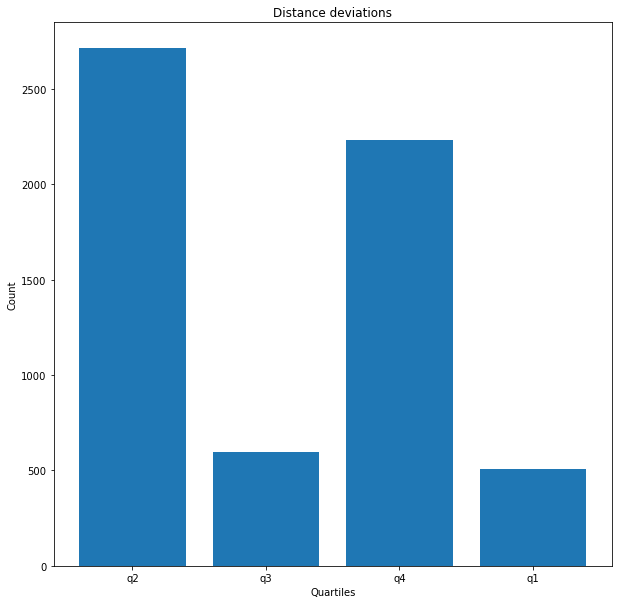

In [152]:
deviations = {}
q1 = {}
q2 = {}
q3 = {}
q4 = {}
for call_event in call_events:
    if (call_event['distanceDeviation'] > 2):
        if call_event['user_id']['$oid'] in list(reps_customers_count_q1.keys()):
            if call_event['user_id']['$oid'] in q1:
                q1[call_event['user_id']['$oid']] += 1
            else:
                q1[call_event['user_id']['$oid']] = 1

            if 'q1' in deviations:
                deviations['q1'] += 1
                
            else:
                deviations['q1'] = 1

        if call_event['user_id']['$oid'] in list(reps_customers_count_q2.keys()):
            if call_event['user_id']['$oid'] in q2:
                q2[call_event['user_id']['$oid']] += 1
            else:
                q2[call_event['user_id']['$oid']] = 1
            
            if 'q2' in deviations:
                deviations['q2'] += 1
            else:
                deviations['q2'] = 1

        if call_event['user_id']['$oid'] in list(reps_customers_count_q3.keys()):
            if call_event['user_id']['$oid'] in q3:
                q3[call_event['user_id']['$oid']] += 1
            else:
                q3[call_event['user_id']['$oid']] = 1
            
            if 'q3' in deviations:
                deviations['q3'] += 1
            else:
                deviations['q3'] = 1

        if call_event['user_id']['$oid'] in list(reps_customers_count_q4.keys()):
            if call_event['user_id']['$oid'] in q4:
                q4[call_event['user_id']['$oid']] += 1
            else:
                q4[call_event['user_id']['$oid']] = 1
            
            if 'q4' in deviations:
                deviations['q4'] += 1
            else:
                deviations['q4'] = 1


# Create a bar chart of the deviation counts
deviations_quartiles = list(deviations.keys())
deviations_counts = list(deviations.values())

fig = plt.figure(figsize=(10, 10))
plt.bar(deviations_quartiles, deviations_counts)

# Add labels and title to the chart
plt.xlabel('Quartiles')
plt.ylabel('Count')
plt.title('Distance deviations')


# Display the chart
plt.show()



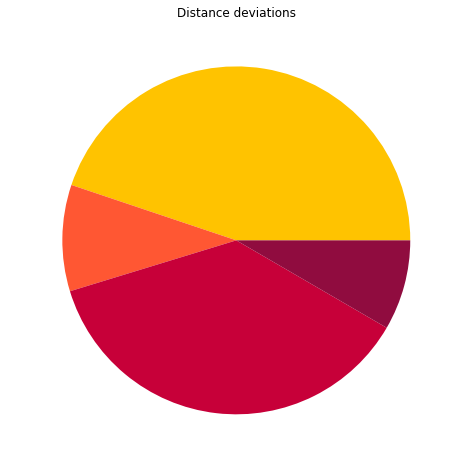

First quartile user's deviations {'60991087ec46a6508e80de9f': 326, '622da6ad5edd2e1b182be6e8': 45, '5da46cb6565e290015188596': 50, '6088317c1b0cd32097b8099c': 4, '622dc11a5edd2e1b182bf467': 5, '63381aba00040d62460cd738': 68, '63381afe00040d62460cd759': 9}
Second quartile user's deviations {'609277b11b0cd32097b8dc32': 467, '61fb82aa9bc51b4d552c0f29': 213, '5da46d08565e290015188598': 379, '5da46f92565e2900151885b8': 145, '60eafba5bac6bd5ba961b161': 234, '5da46b46565e29001518857c': 490, '5da46ce7565e290015188597': 278, '628b3c337ee2c0232015abd3': 507}
Third quartile user's deviations {'5da46d6e565e29001518859a': 50, '627a2aa8042459270f281af4': 84, '6277b4aea6a55c55f7197195': 248, '5da46d9f565e29001518859b': 5, '6085619506454d220fcac4a0': 49, '631142831fb1de726b649c49': 96, '636cbf7a6d339d59ca690006': 66}
Fourth quartile user's deviations {'5da46aab565e29001518857a': 149, '6061c07af7606271c5c4da3d': 754, '60b741421ab64b1c837e01a4': 770, '627671a44318a823e6f71806': 178, '5da46c8d565e2900151

In [155]:

# Create a pie chart
custom_colors = ['#FFC300', '#FF5733', '#C70039', '#900C3F']
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(deviations_counts, labels=deviations_quartiles,
       colors=custom_colors, labeldistance=1.2, textprops={'color': 'white', 'fontsize': 16})
# Add a title
plt.title('Distance deviations')
# Show the chart
plt.show()

print("First quartile user's deviations", q1)
print("Second quartile user's deviations", q2)
print("Third quartile user's deviations", q3)
print("Fourth quartile user's deviations", q4)
